In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/journal_synthetic.csv")
df.head()


,Region,City,County,Entity,District,Gross,Taxable,InputSource,PlaceDetermination,EntryId,Id,LogId,TaxRate,Year,Month
0,US-FL,Boca Raton,Palm Beach,PizzaHut,District-50,5192.56,363.48,balanceimport,taxareacode,100000,J100000,L100000,0.0700,2023,3
1,US-MI,Troy,Oakland,PizzaHut,District-13,5632.31,464.67,balanceimport,taxareacode,100001,J100001,L100001,0.0825,2022,12
2,US-NC,Charlotte,Mecklenburg,Reliance,District-27,6192.36,789.53,balanceimport,taxareacode,100002,J100002,L100002,0.1275,2024,5
3,US-NY,Manhattan,New York,PizzaHut,District-43,5284.76,418.02,balanceimport,taxareacode,100003,J100003,L100003,0.0791,2023,1
4,US-GA,Smyrna,Cobb,Reliance,District-35,8228.46,1209.58,balanceimport,taxareacode,100004,J100004,L100004,0.1470,2023,12


In [14]:
# Check for null values in df
df_nulls = df.isnull().sum()
print("Null values in df:")
display(df_nulls)

Null values in df:


Region                0
City                  0
County                0
Entity                0
District              0
Gross                 0
Taxable               0
InputSource           0
PlaceDetermination    0
EntryId               0
Id                    0
LogId                 0
TaxRate               0
Year                  0
Month                 0
dtype: int64

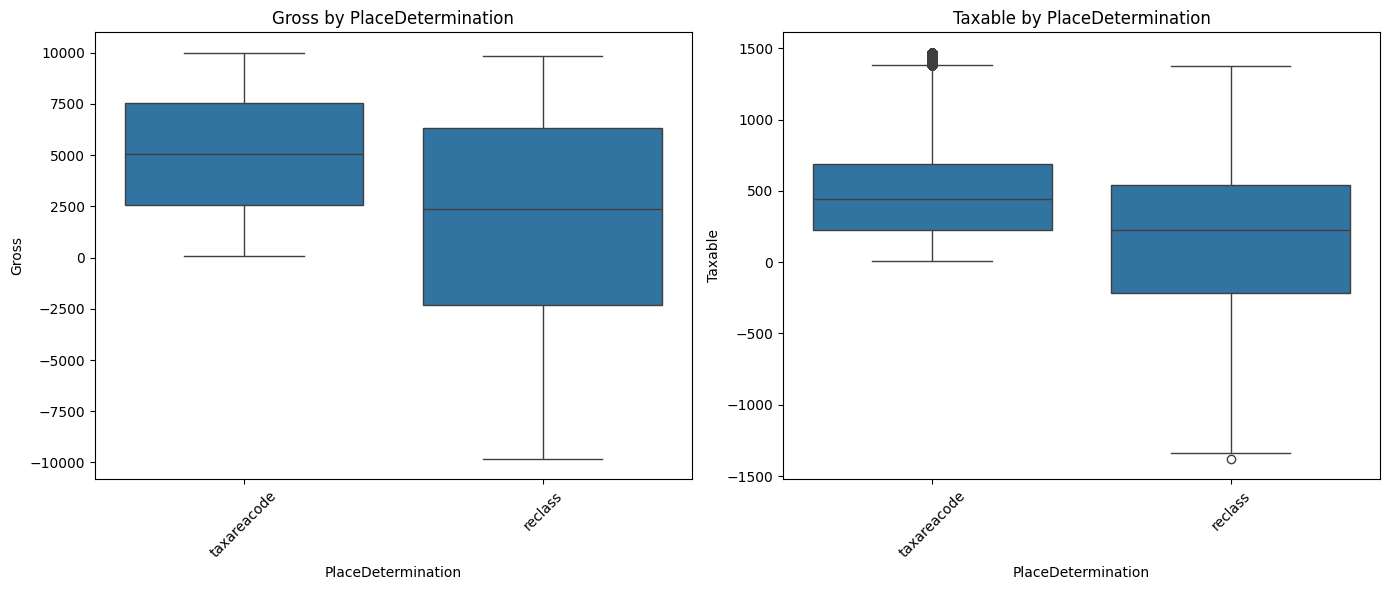

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Distribution of Gross and Taxable
# Visualize Gross and Taxable by PlaceDetermination (reclass states)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="PlaceDetermination", y="Gross", data=df)
plt.title("Gross by PlaceDetermination")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x="PlaceDetermination", y="Taxable", data=df)
plt.title("Taxable by PlaceDetermination")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

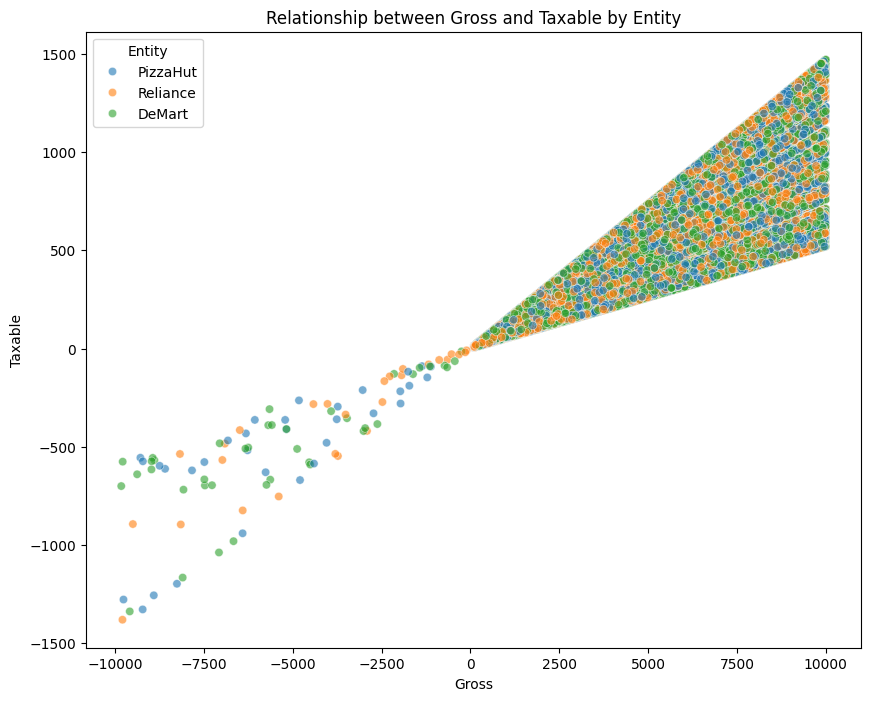

In [16]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Gross', y='Taxable', data=df, alpha=0.6, hue='Entity')
plt.title('Relationship between Gross and Taxable by Entity')
plt.xlabel('Gross')
plt.ylabel('Taxable')
plt.show()

In [17]:
# Read test data
test_df = pd.read_csv("../data/reconcillation_synthetic.csv")

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Load CSV files
journal_df = pd.read_csv("../data/journal_synthetic.csv")
recon_df = pd.read_csv("../data/reconcillation_synthetic.csv")

# Filter for UnreportedTax > 0
recon_unreported = recon_df[recon_df['UnreportedTax'] > 0]

# Define common features
features = ['Region', 'County', 'Entity', 'Gross', 'Taxable', 'TaxRate', 'Year', 'Month']

# Combine both datasets for consistent one-hot encoding
combined_df = pd.concat([journal_df[features], recon_unreported[features]], axis=0)
encoded_df = pd.get_dummies(combined_df, drop_first=True)

# Separate encoded datasets
X_encoded = encoded_df[:len(journal_df)]
X_predict = encoded_df[len(journal_df):]

# Encode target variable (City)
le = LabelEncoder()
y = le.fit_transform(journal_df['City'])

# Split training set for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define parameter grid for RandomForest
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Train Logistic Regression
model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

clf = grid_search.best_estimator_

# Evaluate model
y_pred_test = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

# Predict on reconciliation entries
y_pred_recon = clf.predict(X_predict)
predicted_cities = le.inverse_transform(y_pred_recon)

# Attach predictions to the filtered reconciliation data
recon_unreported = recon_unreported.copy()
recon_unreported['Predicted_City'] = predicted_cities

# Save output
recon_unreported.to_csv("predicted_reconciliation_results.csv", index=False)

# Print sample and metrics
print("Sample Predictions:\n", recon_unreported[['Region', 'County', 'Entity', 'UnreportedTax', 'Predicted_City']].head())
print("\nAccuracy on Test Set: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", report)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
